## Process protein complex membership

**Input:** Protein complexes from CORUM + CERES gene scores + processed paralog pairs

**Output:** Paralog pairs annotated with protein complex features

Note: For some complexes more genes are listed in the gene name column than in the entrez id column (i.e. there are not enough 'None' placeholders). Example complex is 824, SMN1 and SMN2 are both not included in the id list but there is only one 'None' entry.

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

get_data_path = lambda folders, fname: os.path.normpath(os.environ['3RD_PARTY_DIR']+'/'+'/'.join(folders) +'/'+ fname)
get_local_data_path = lambda folders, fname: os.path.normpath('../../local_data/' +'/'.join(folders) +'/'+ fname)

# Inputs
file_CORUM_complexes = get_data_path(['CORUM'], 'allComplexes.txt')
file_gene_id_map = get_local_data_path(['processed'], 'HGNC_gene_id_map.csv')
file_gene_scores = get_local_data_path(['processed', 'depmap20Q2'], 'gene_scores_26_05_20.csv')
file_paralog_pairs = get_local_data_path(['processed','ensembl93'], 'unique_pairs.csv')

# Output
file_complex_features = get_local_data_path(['processed','paralog_features'], 'protein_complex_features.csv')

### Make map of entrez-id/symbol to complex id

Some sub-units are associated with multiple genes. For example complex 3298 has gene name "SMN1; SMN2" for one of its sub-units. In the sub units gene list these are indicated by a space after the semi-colon symbol.

In [3]:
all_complexes = pd.read_csv(file_CORUM_complexes, sep='\t')

In [4]:
# Reduce down to human complexes
human_complexes = all_complexes[all_complexes.Organism == 'Human'].reset_index(drop=True)
human_complexes = human_complexes[['ComplexID', 'ComplexName', 'subunits(Entrez IDs)', 'subunits(Gene name)']]
human_complexes = human_complexes.rename(columns={'subunits(Entrez IDs)':'subunits_entrez_id',
                                                  'subunits(Gene name)':'subunits_symbol'})
human_complexes['subunits_symbol'] = human_complexes.subunits_symbol.apply(lambda x: x.replace(';;', ';'))
print('Num complexes:', human_complexes.ComplexID.nunique())
human_complexes[:2]

Num complexes: 2916


,ComplexID,ComplexName,subunits_entrez_id,subunits_symbol
0,1,BCL6-HDAC4 complex,604;9759,BCL6;HDAC4
1,2,BCL6-HDAC5 complex,604;10014,BCL6;HDAC5


In [5]:
# QC - disagreement in subunit counts
# Discrepancy in counts is always entrez ids < gene symbols
# Some of the complexes include 'None' as one of the entrez ids
df = human_complexes.assign(entrez_id_count = human_complexes.subunits_entrez_id.apply(lambda x: x.count(';')),
                            symbol_count = human_complexes.subunits_symbol.apply(lambda x: x.count(';')))
print('N diff subunit counts:', df[df.entrez_id_count != df.symbol_count].shape[0])
df[df.entrez_id_count != df.symbol_count].iloc[16:19]

N diff subunit counts: 24


,ComplexID,ComplexName,subunits_entrez_id,subunits_symbol,entrez_id_count,symbol_count
1481,3298,"SMN complex (GEMIN2,5, SMN)",8487;None;25929,GEMIN2;SMN1; SMN2;GEMIN5,2,3
1537,4158,HSP90-FKBP38-CAM-Ca(2+) complex,3320;None;23770,HSP90AA1;CALM1; CAL;FKBP8,2,3
1576,5189,YWHAQ-CALM1-CABIN1 complex,10971;None;23523,YWHAQ;CALM1; CAL;CABIN1,2,3


In [6]:
# Add different symbol for multiple gene names per entrez entry
complexes = human_complexes.assign(subunits_symbol = human_complexes.subunits_symbol.apply(lambda x: x.replace('; ', '|')))
complexes.loc[1481:1481]

,ComplexID,ComplexName,subunits_entrez_id,subunits_symbol
1481,3298,"SMN complex (GEMIN2,5, SMN)",8487;None;25929,GEMIN2;SMN1|SMN2;GEMIN5


In [7]:
# Stack the list of ids associated with each complex id - to get pairs of (complex id, entrez id / symbol)
df1 = complexes.set_index('ComplexID').subunits_entrez_id.apply(lambda x: pd.Series(x.split(';')))\
               .stack().reset_index(level=1, drop=True).reset_index().rename(columns={0:'entrez_id'})
df2 = complexes.set_index('ComplexID').subunits_symbol.apply(lambda x: pd.Series(x.split(';')))\
               .stack().reset_index(level=1, drop=True).reset_index().rename(columns={0:'symbol'})
assert(df1.shape[0] == df2.shape[0])
subunits_map = pd.concat([df1, df2.drop(columns=['ComplexID'])], axis=1)
display(subunits_map[:1])

# Split out symbols with | (stack those as well)
subunits_map = subunits_map.set_index(['ComplexID', 'entrez_id']).symbol.apply(lambda x: pd.Series(x.split('|'))).stack()\
                           .reset_index(level=2, drop=True).reset_index().rename(columns={0:'symbol'})

# Check for entrez ids / symbols not in HGNC - drop these rows
gene_id_map = pd.read_csv(file_gene_id_map).dropna(subset=['entrez_id'])[['entrez_id','symbol']]
gene_id_map = gene_id_map.astype({'entrez_id':'int'}).astype({'entrez_id':'str'})
print('N entrez ids not in HGNC:', subunits_map[~subunits_map.entrez_id.isin(gene_id_map.entrez_id)].entrez_id.nunique()-1)
subunits_map = subunits_map[subunits_map.entrez_id.isin(gene_id_map.entrez_id) | 
                            subunits_map.symbol.isin(gene_id_map.symbol)].reset_index(drop=True)

# Fill in the entrez ids where ids were recorded as None in CORUM
df = pd.merge(subunits_map[subunits_map.entrez_id=='None'].drop(columns=['entrez_id']), gene_id_map)
assert(df.shape[0] == subunits_map[subunits_map.entrez_id=='None'].shape[0])
subunits_map = pd.concat([subunits_map[subunits_map.entrez_id!='None'], df]).reset_index(drop=True)

# Clean up
complex_map = subunits_map.rename(columns={'ComplexID':'complex_id'}).sort_values('complex_id').drop(columns=['symbol'])
complex_map = complex_map.astype({'entrez_id':'int'})
print('Num genes:', complex_map.entrez_id.nunique())
print('Num complexes:', complex_map.complex_id.nunique())
complex_map[:2]

,ComplexID,entrez_id,symbol
0,1,604,BCL6


N entrez ids not in HGNC: 9
Num genes: 3649
Num complexes: 2916


,complex_id,entrez_id
0,1,604
1,1,9759


### Calculate complex membership for paralog pairs

In [8]:
pairs = pd.read_csv(file_paralog_pairs, index_col=0)[['A1','A2','A1_entrez','A2_entrez']]
print('Num pairs:', pairs.shape[0])
pairs[:1]

Num pairs: 36648


,A1,A2,A1_entrez,A2_entrez
0,A1BG,OSCAR,1,126014


In [9]:
complexes_per_gene = complex_map.groupby('entrez_id').agg({'complex_id': set}).reset_index()
display(complexes_per_gene[:2])

# Merge with each gene in all pairs 
df = pd.merge(pairs[['A1_entrez','A2_entrez']], 
              complexes_per_gene.rename(columns={'entrez_id':'A1_entrez','complex_id':'A1_complex_ids'}), how='left')
df = pd.merge(df, complexes_per_gene.rename(columns={'entrez_id':'A2_entrez','complex_id':'A2_complex_ids'}), how='left')

# Fill in empty sets (gene not in a complex)
df.loc[df.A1_complex_ids.isna(),'A1_complex_ids'] = df.loc[df.A1_complex_ids.isna(),'A1_complex_ids'].apply(lambda x: set())
df.loc[df.A2_complex_ids.isna(),'A2_complex_ids'] = df.loc[df.A2_complex_ids.isna(),'A2_complex_ids'].apply(lambda x: set())

# Calculate complex intersection and union
df = df.assign(complex_intersection=df.apply(lambda x: x.A1_complex_ids.intersection(x.A2_complex_ids), axis=1),
               complex_union=df.apply(lambda x: x.A1_complex_ids.union(x.A2_complex_ids), axis=1))

# Calculate features
df['either_in_complex'] = df.complex_union.apply(lambda x: len(x) > 0)
df['in_same_complex'] = df.complex_intersection.apply(lambda x: len(x) > 0)

complex_membership = df
complex_membership[:2]

,entrez_id,complex_id
0,2,{2710}
1,12,{5389}


,A1_entrez,A2_entrez,A1_complex_ids,A2_complex_ids,complex_intersection,complex_union,either_in_complex,in_same_complex
0,1,126014,{},{},{},{},False,False
1,1,441864,{},{},{},{},False,False


In [10]:
print('Either in complex:', sum(complex_membership.either_in_complex))
assert(sum(complex_membership.either_in_complex) == 
       pairs[pairs.A1_entrez.isin(complex_map.entrez_id) | pairs.A2_entrez.isin(complex_map.entrez_id)].shape[0])
print('In same complex:', sum(complex_membership.in_same_complex))

complex_membership[complex_membership.in_same_complex][:2]

Either in complex: 8060
In same complex: 402


,A1_entrez,A2_entrez,A1_complex_ids,A2_complex_ids,complex_intersection,complex_union,either_in_complex,in_same_complex
15,10236,10492,"{3082, 1181, 1223}","{5385, 1307, 1181, 6838}",{1181},"{6838, 1223, 5385, 3082, 1307, 1181}",True,True
205,64240,64241,{7263},{7263},{7263},{7263},True,True


### Calculate essentiality of complexes in which pairs are members

In [11]:
# Load gene scores
gene_scores_raw = pd.read_csv(file_gene_scores, index_col=0)
print('Gene scores:', gene_scores_raw.shape)
gene_scores_raw[:1]

Gene scores: (769, 16445)


,1,29974,2,144568,127550,53947,51146,8086,65985,13,...,221302,9183,55055,11130,79364,440590,79699,7791,23140,26009
ACH-001382,0.652347,-0.020793,-0.270112,-0.211408,0.06271,-0.081674,0.37684,-0.767385,0.166991,0.112045,...,0.182055,-0.724872,0.499652,-0.141164,-0.336501,0.250665,-0.676302,-0.098001,-0.677497,-0.506629


In [29]:
# Compute % of cell lines in which gene is essential + the avg. CERES score for each gene
gene_scores = pd.merge(gene_scores_raw.apply(lambda x: (x < -0.6).sum() / gene_scores_raw.shape[0]).reset_index(),
                       gene_scores_raw.mean().reset_index(), on=['index'])
gene_scores = gene_scores.rename(columns={'index':'entrez_id', '0_x':'essential_percent', '0_y':'avg_ceres_score'})
gene_scores = gene_scores.astype({'entrez_id':'int'})
print('Mean essential %%: %.3f, mean CERES: %.2f' % (gene_scores.essential_percent.mean()*100, 
                                                     gene_scores.avg_ceres_score.mean()))
display(gene_scores[:1])

Mean essential %: 10.617, mean CERES: -0.16


,entrez_id,essential_percent,avg_ceres_score
0,1,0.0,0.092681


Corr: -0.9239975268049923


<AxesSubplot:xlabel='essential_percent', ylabel='avg_ceres_score'>

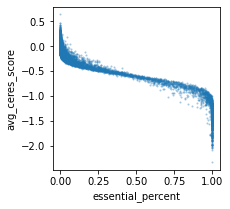

In [34]:
# Check correlation between avg CERES score and essential percent
f, ax = plt.subplots(1, 1, figsize=(3,3))
print('Corr:', gene_scores.essential_percent.corr(gene_scores.avg_ceres_score))
sns.scatterplot(gene_scores.essential_percent, gene_scores.avg_ceres_score, linewidth=0, alpha=0.4, s=4, ax=ax)

In [30]:
# Merge essentiality for each subunit gene
subunit_essentiality = pd.merge(complex_map, gene_scores, how='left')
print('N subunits w/out score:', subunit_essentiality[subunit_essentiality.essential_percent.isna()].entrez_id.nunique())
display(subunit_essentiality[:2])

N subunits w/out score: 253


,complex_id,entrez_id,essential_percent,avg_ceres_score
0,1,604,0.022107,-0.076898
1,1,9759,0.055917,-0.278885


In [31]:
# Stack complex membership (union of complexes) for paralog pairs, to get one row for each (A1, A2, complex_id) tuple
df = complex_membership.set_index(['A1_entrez','A2_entrez'])['complex_union'].apply(list).apply(pd.Series).stack()\
                       .reset_index().drop(columns=['level_2']).rename(columns={0:'complex_id'}).astype({'complex_id':'int'})
display(df[:2])

# Merge with subunit scores - expands to multiple rows per (A1, A2, complex_id) tuple
df = pd.merge(df, subunit_essentiality)
assert(df.drop_duplicates(subset=['A1_entrez','A2_entrez']).shape[0] == sum(complex_membership.either_in_complex))
display(df[:2])

# Filter out sub-units that are either A1 or A2 before computing avg. essentiality of sub-units
df = df[(df.A1_entrez != df.entrez_id) & (df.A2_entrez != df.entrez_id)].reset_index(drop=True)

# Compute essentiality scores for each (A1, A2, complex) tuple
def any_broadly(x): return np.sum(x > 0.9) > 0
complex_essentiality = df.groupby(['A1_entrez','A2_entrez','complex_id'])\
                         .agg({'essential_percent':[any_broadly, 'mean'], 'avg_ceres_score':'mean'})

complex_essentiality.columns = ['essential_complex', 'mean_essentiality', 'mean_ceres_score']
complex_essentiality = complex_essentiality.reset_index()
complex_essentiality[:2]

,A1_entrez,A2_entrez,complex_id
0,29974,10236,3082
1,29974,10236,1181


,A1_entrez,A2_entrez,complex_id,entrez_id,essential_percent,avg_ceres_score
0,29974,10236,3082,3609,0.988296,-1.139802
1,29974,10236,3082,10236,0.323797,-0.526979


,A1_entrez,A2_entrez,complex_id,essential_complex,mean_essentiality,mean_ceres_score
0,2,718,2710,False,0.009753,-0.130884
1,2,718,6107,False,0.001300,0.003969


In [32]:
# Compute essentiality scores for each (A1, A2) pair
avg_complex_essentiality = complex_essentiality.groupby(['A1_entrez','A2_entrez']).agg({'essential_complex':'max', 
                                                                                         'mean_essentiality':'mean'})
avg_complex_essentiality.columns = ['either_in_essential_complex', 'mean_complex_essentiality']
avg_complex_essentiality = avg_complex_essentiality.reset_index()
avg_complex_essentiality['flag_missing_scores'] = avg_complex_essentiality.mean_complex_essentiality.isna()
    
print('N either in essential complex:', sum(avg_complex_essentiality.either_in_essential_complex),'/',
      avg_complex_essentiality.shape[0]) 
print('N missing scores:', avg_complex_essentiality[avg_complex_essentiality.flag_missing_scores].shape[0])
avg_complex_essentiality[:2]

N either in essential complex: 2487 / 7980
N missing scores: 60


,A1_entrez,A2_entrez,either_in_essential_complex,mean_complex_essentiality,flag_missing_scores
0,2,718,False,0.004551,False
1,2,720,False,0.009753,False


### Export all protein complex features for paralog pairs

In [33]:
# Merge with all pairs (NaNs for pairs not in any complexes)
complex_features = pd.merge(
    complex_membership[['A1_entrez', 'A2_entrez', 'either_in_complex', 'in_same_complex']], 
    avg_complex_essentiality, how='left')
complex_features = complex_features.fillna({'either_in_essential_complex':False, 'flag_missing_scores':False})

print('Either in complex:', sum(complex_features.either_in_complex),'/',complex_features.shape[0])
print('Same complex:', sum(complex_features.in_same_complex))
print('Either in essential complex:', sum(complex_features.either_in_essential_complex))

print('Complex members without scores b/c of missing gene scores (CERES):', 
       complex_features[complex_features.flag_missing_scores].shape[0])

assert(complex_features.shape[0] == pairs.shape[0])
complex_features[:1]

Either in complex: 8060 / 36648
Same complex: 402
Either in essential complex: 2487
Complex members without scores b/c of missing gene scores (CERES): 60


,A1_entrez,A2_entrez,either_in_complex,in_same_complex,either_in_essential_complex,mean_complex_essentiality,flag_missing_scores
0,1,126014,False,False,False,NaN,False


In [20]:
complex_features.to_csv(file_complex_features, index=0)

### Complex membership and essentiality for ASF1A/ASF1B

In [28]:
display(pd.merge(pairs[(pairs.A1=='ASF1A') & (pairs.A2=='ASF1B')], complex_membership))
display(pd.merge(pd.merge(pairs[(pairs.A1=='ASF1A') & (pairs.A2=='ASF1B')], complex_essentiality),
                 complex_map.groupby('complex_id').count().rename(columns={'entrez_id':'n_subunits'}).reset_index()))

,A1,A2,A1_entrez,A2_entrez,A1_complex_ids,A2_complex_ids,complex_intersection,complex_union,either_in_complex,in_same_complex
0,ASF1A,ASF1B,25842,55723,"{6149, 2235, 2236, 1149, 1150}","{2235, 2236, 1149, 1150}","{2235, 2236, 1149, 1150}","{6149, 2235, 2236, 1149, 1150}",True,True


,A1,A2,A1_entrez,A2_entrez,complex_id,essential_complex,mean_essentiality,mean_ceres_score,n_subunits
0,ASF1A,ASF1B,25842,55723,1149,True,0.553316,-0.810206,8
1,ASF1A,ASF1B,25842,55723,1150,True,0.439012,-0.530151,7
2,ASF1A,ASF1B,25842,55723,2235,True,0.957521,-1.361864,5
3,ASF1A,ASF1B,25842,55723,2236,True,0.355332,-0.641094,6
4,ASF1A,ASF1B,25842,55723,6149,False,0.425228,-0.631730,3


### Distribution

In [9]:
complex_features = pd.read_csv(file_complex_features)

<AxesSubplot:xlabel='mean_complex_essentiality'>

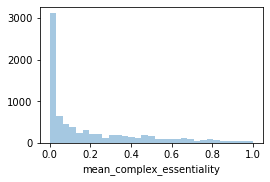

In [26]:
f, ax = plt.subplots(1, 1, figsize=(4,2.5))
sns.distplot(complex_features.mean_complex_essentiality.dropna(), kde=False)